In [400]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pytz

import json
import os 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
parent = os.path.dirname(os.path.abspath("__file__"))
StrongPath = os.path.join(parent, 'StrongTickers')
if not os.path.isdir(StrongPath):
    os.makedirs(StrongPath)
import warnings
warnings.filterwarnings("ignore")

# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
api = sj.Shioaji()
api.login('F128497445', '89118217k')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [3]:
results = {}

In [4]:
from typing import Callable, List
from enum import Enum

from datetime import datetime, timedelta

from typing import List
from copy import deepcopy

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class BaseData(AttrDict):
    
    def __init__(self, *args, **kwargs):
        super(BaseData, self).__init__(*args, **kwargs)
        
class TickData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(TickData, self).__init__(*args, **kwargs)
        
class BarData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(BarData, self).__init__(*args, **kwargs)

class TradeMode(Enum):
    """
    交易模式
    """
    REALTIME = '實盤交易'
    SIMULATION = '模擬交易'
    BACKTEST = '回測'
    BACKTESTINTRADAY = '日內回測'

# 資料格式 (RealTime)
class Interval(Enum):
    """
    資料頻率
    """
    TICK = '逐筆'
    MINUTE = '分K'
    HOUR = '小時K'
    DAILY = '日K'

class BarGenerator:
    """
    For:
    1. generateing x minute bar/x hour bar data from tick data

    Notice:
    1. x can be any number
    """

    def __init__(self, ticker: str, interval: Interval = Interval.MINUTE, window: int = 5,
                 trademode: TradeMode = TradeMode.REALTIME, 
                 callback: Callable = None, size=15, date=datetime.today()):
        """
        Constructor
        """
        self.ticker = ticker
        self.interval = interval
        self.window = window
        self._trademode = trademode
        self.callback = callback

        self.setupBarCycle(interval, window)
        self.bars: List[BarData] = []
        self.inited = False
        self.barCount = 0
        self.size = size
        self.date = date

    def setupBarCycle(self, interval, window) -> None:
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            self.current = date.replace(hour=9,minute=0,second=0,microsecond=0)#datetime.now().replace(second=0)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            self.current = 84500
        self._intervalCycle(interval, window)

    def _intervalCycle(self, interval: Interval, window: int):
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            if interval == Interval.MINUTE:
                self.cycle = timedelta(seconds=60 * window)
            elif interval == Interval.HOUR:
                self.cycle = timedelta(seconds=60 * 60 * window)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            if interval == Interval.MINUTE:
                self.cycle = 100 * window
            elif interval == Interval.HOUR:
                self.cycle = 100 * 100 * window

    def updateBar(self, tick: TickData):
        try:
            if self._trademode == TradeMode.BACKTESTINTRADAY:
                return self._updateBarBacktest(tick)
            return self._updateBar(tick)
        except:
            raise

    def _updateBar(self, tick: TickData):
        try:
            try:
                time, close, volume = tick.time, tick.close, tick.volume
            except:
                # print(tick)
                time, close, volume = tick['time'], tick['close'], tick['volume']
            if not self.bars or time > self.current:
                self.bars.append(self._createNewBar(time, close, volume))
                self._updateCurBarTime()
                if len(self.bars) >= self.size:
                    self.inited = True
                if len(self.bars) > 1:
#                     print(self.bars[-2])
                    return self.bars[-2]
                    if self.callback:
                        self.callback(self.bars[-2])
            else:
                self._updateCurBar(close, volume)
        except:
            raise

    def _updateBarBacktest(self, tick: TickData):
        time, close, volume = tick.time, tick.close, tick.volume
        if not self.bars or time > self.current:
            self.bars.append(self._createNewBar(time, close, volume))
            self._updateCurBarTime()
            if len(self.bars) >= self.size:
                self.inited = True
            if len(self.bars) > 1:
                self.callback(self.bars[-2])
        else:
            self._updateCurBar(close, volume)
            
    def _createNewBar(self, time, close, volume):
        return BarData(
                    symbol=self.ticker,
                    time=time,
                    open=close,
                    high=close,
                    low=close,
                    close=close,
                    volume=volume
                )
    
    def _updateCurBar(self, close, volume):
        curBar = self.bars[-1]
        curBar.high = max(curBar.high, close)
        curBar.low = min(curBar.low, close)
        curBar.close = close
        curBar.volume += volume
        self.bars[-1] = curBar

    def _updateCurBarTime(self):
        self.current += self.cycle
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            return
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            timeList = self._intTolist(self.current)
            if self.interval == Interval.MINUTE:
                if timeList[1] >= 60:
                    timeList[0] += 1
                    timeList[1] -= 60
            if timeList[0] >= 24:
                timeList[0] -= 24
            self.current = int(''.join([str(int(x)) for x in timeList]))

    def _intTolist(self, t):
        ss = t % 100
        t /= 100
        mm = t % 100
        hh = t / 100
        return [int(hh), int(mm), int(ss)]

    @property
    def closes(self):
        return [getattr(bar, 'close') for bar in self.bars][:-1]

    @property
    def opens(self):
        return [getattr(bar, 'open') for bar in self.bars][:-1]

    @property
    def highs(self):
        return [getattr(bar, 'high') for bar in self.bars][:-1]

    @property
    def lows(self):
        return [getattr(bar, 'low') for bar in self.bars][:-1]

    @property
    def volumes(self):
        return [getattr(bar, 'volume') for bar in self.bars][:-1]

In [528]:
def readStrongTicker(dtStr, atr=""):
    datapath = os.path.join(StrongPath+atr, f'{dtStr}_tradableTicker.json')
    if not os.path.isfile(datapath):
        datapath = os.path.join(StrongPath+atr, f'{dtStr}_strongTicker.json')
#         with open(os.path.join(StrongPath, f'{dtStr}_tradableTicker.json'), 'r') as f:
#             tickers = json.load(f)
#             return tickers
    if os.path.isfile(datapath):
        with open(datapath, 'r') as f:
            tickers = json.load(f)
            return tickers
    else:
        return {}

def get_minimum_tick(cost):
    if cost < 10:
        return 0.01
    elif cost < 50:
        return 0.05
    elif cost < 100:
        return 0.1
    elif cost < 500:
        return 0.5
    elif cost < 1000:
        return 1
    else:
        return 5
    
def getLimit(price, pct=0.1, trend="U"):
    tmp_price = price
    if trend == "U":
        while 1:
            tick = get_minimum_tick(tmp_price)
            tmp_price += tick
            if (tmp_price/price) > 1 + pct:
                tmp_price -= tick
                break
    elif trend == "D":
        while 1:
            tick = get_minimum_tick(tmp_price)
            tmp_price -= tick
            if (tmp_price/price) < 1 - pct:
                tmp_price += tick
                break
            
    return round(tmp_price, 2)
    
def get_commission(price:float, multiplier:int=1000, qty=1, Real:bool=True, direction:str='', dayTrade:bool=False):
    """
    計算個別部位的單邊交易成本

    Params:
        symbol : 商品代碼
        exchange : 交易所
        cost : 交易價格
        multiplier : 價格還原現金之乘數
            例如:
                股票 : 1張 = 1,000股，10元的股票還原現金價值，即為10 *1,000 = 10,000元
                期貨 : 台指期1點200元，假設現在10,000點，則一口台股的價值為 200 * 10,000 = 2,000,000
        qty : 買賣口數或張數
        Real : 是否為實單, default = False
        direction : 交易方向 進場(買賣)或出場
            P.S. 股票交易的交易稅是出場才計算
    """
    tick = get_minimum_tick(price)
    commission = price * (0.1425 / 100) * multiplier * qty
    commission = 20 if commission < 20 else commission
    fee = price * (0.3 / 100) * multiplier * qty
    if dayTrade:
        fee /= 2
    slide = tick * multiplier
    tradeCost = commission * 0.6
    if direction == 'EXIT' or direction == 0:
        tradeCost += fee
    if not Real:
        tradeCost += slide * qty
    return tradeCost

In [6]:
def ReadData(api, ticker, date):
    dateStr = date.strftime("%Y-%m-%d")
    contact = api.Contracts.Stocks[ticker]
    data = api.ticks(contact, dateStr, 
            query_type=sj.constant.TicksQueryType.RangeTime, 
            time_start='09:00:00',#datetime(2021,11,5,8,45,0).time(),
           time_end='13:30:00')#datetime(2021,11,5,13,45,0).time())
    df = pd.DataFrame(data.dict())
    df['datetime'] = df.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')))
    df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f")))
    return df

In [513]:
def CalculateTrend(data, show_fig=False):
    from scipy.stats import linregress
    data0 = data.copy()#.iloc[:20]
    data0['date_id'] = list(range(data0.shape[0])) # data0['date_id'].dt.minutes
    data0['Adj High'] = data0['high']#data0[['open','close']].max(axis=1)
    data0['Adj Low'] = data0['low']#data0[['open','close']].min(axis=1)
    # high trend line
    data1 = data0.copy()
#     print(data1.tail())
    while len(data1)>3:

        reg = linregress(
                        x=data1['date_id'],
                        y=data1['Adj High'],
                        )
        data1 = data1.loc[data1['Adj High'] > reg[0] * data1['date_id'] + reg[1]]

    if data1.empty:
        reg = linregress(
                            x=data0['date_id'],
                            y=data0['Adj High'],
                            )
    else:
        reg = linregress(
                            x=data1['date_id'],
                            y=data1['Adj High'],
                            )


    data0['high_trend'] = reg[0] * data0['date_id'] + reg[1]
    estimate_high = reg[0] * (data0['date_id'].iloc[-1] + 1) + reg[1]

    # low trend line

    data1 = data0.copy()
    while len(data1)>3:
        reg = linregress(
                        x=data1['date_id'],
                        y=data1['Adj Low'],
                        )
        data1 = data1.loc[data1['Adj Low'] < reg[0] * data1['date_id'] + reg[1]]
        
    if data1.empty:
        reg = linregress(
                            x=data0['date_id'],
                            y=data0['Adj Low'],
                            )
    else:
        reg = linregress(
                            x=data1['date_id'],
                            y=data1['Adj Low'],
                            )

    data0['low_trend'] = reg[0] * data0['date_id'] + reg[1]
    estimate_low = reg[0] * (data0['date_id'].iloc[-1] + 1) + reg[1]
#     print(data0)
    data0 = data0.reset_index().append(
        pd.DataFrame([{
            "time":data0.index[-1] + (data0.index[-1] - data0.index[-2]),
            "symbol":list(data0.symbol.unique())[0],
            "open":float("nan"), #data0.open.iloc[-1],
            "high":float("nan"), #data0.high.iloc[-1],
            "low":float("nan"), #data0.low.iloc[-1],
            "close":float("nan"), #data0.close.iloc[-1],
            "volume":0,
            "high_trend":estimate_high,
            "low_trend":estimate_low,
        }])
    ).set_index("time")
#     print(data0.tail())
    # plot
    if show_fig:
#         print(data0.high_trend)
#         print(data0.low_trend)
        fig = go.Figure(data=[go.Candlestick(x=data0.index,
                        open=data0.open,
                        high=data0.high,
                        low=data0.low,
                        close=data0.close)])
        fig.add_trace(
            go.Scatter(
                x=data0.index,
                y=data0.high_trend,
                name = 'high_trend'
            ))
        fig.add_trace(
            go.Scatter(
                x=data0.index,
                y=data0.low_trend,
                name = 'low_trend'
            ))

        fig.show()
    return data0

In [526]:
def backtest(api:sj.Shioaji, ticker:str, date:datetime, open_threshold:float=0, PreData:dict={},
             v_threshold:float=.01, entry_percent:float=.08, exit_percent:float=.09, touch_tp:float=.01, 
             takeprofit:float=.6, start_moving_take = .015, sl_ratio:float=.02, max_size:float = 1, 
             exit_time:str='13:00:00.000000', window=5, ma_len=3, ma_len2 = 5): # 

    # prepare data
    df = ReadData(api, ticker, date)
    
    # setting Parameters
    opening = False
    closing = False
    
    pre_time:str="09:00:00"
    pre_volume:int = 0
    pre_close:int = 0
    total_v:int = 0 
    refPrice:float = PreData.get('PreClose', 0)
    preHigh:float = PreData.get('PreHigh', PreData.get('PreClose', 0))
#     preLow:float = PreData.get('PreLow', 9999)
    entry_threshold:float = 0 if not refPrice else refPrice * (1 + entry_percent)
    exit_threshold:float = 0 if not refPrice else refPrice * (1 + exit_percent)
    max_ret:float = 0
    tmp_ret:float = 0
    pos = 0
    sig = 0
    traded = 0
    long_traded = short_traded = 0
    entry = 0
    entry_time = 0

#     preHigh = 0
#     preLow = 9999
    sl_threshold = 0
    short_sl_ratio = .02
    v_turn_sl_ratio = .02
    
    pnl:float = 0
    total_volume = 0
#     first_5mink = {'open':None, 'high':0,'low':9999, 'close':0}
        
    entry_time = ''
    exit_pos_time = ''
    tmp_pnl = 0
    barG = BarGenerator(ticker, date=date, window=5)
    open_l = open_h = None
    total_pnl = 0
    v_turn = False
    isNewBar = False
    P_v = []
    Vols = []
    VWAP = []
    tPrices = []
    
    MA1 = []
    MA2 = []
    
    Trend=pd.DataFrame()
    up_limit = getLimit(refPrice)
    dn_limit = getLimit(refPrice, trend="D")
    for row in df.itertuples():
#         print(row)
        price = row.close
        time = row.datetime
        qty = row.volume
        if not qty: continue
        total_volume += qty
        tick = TickData(time=time, close=price,volume=qty)
#         print(tick)
        update_bar = barG.updateBar(tick)
        if update_bar:# and not pos:
            tPrice = (update_bar.high + update_bar.low + update_bar.close) / 3
            tPrices.append(tPrice)
            P_v.append(tPrice * update_bar.volume)
            Vols.append(update_bar.volume)
            VWAP.append(sum(P_v) / sum(Vols))
#             print(update_bar)
            
#             if len(barG.bars) >= 3 and not (open_h and open_l):
#                 open_h = max(barG.highs[:2])
#                 open_l = min(barG.lows[:2])
#                 print(f"open_h : {open_h}, open_l : {open_l}")
        
#             isNewBar = True
            if len(barG.bars) < 3:
                continue
#             if len(barG.bars) < ma_len + 1:
#                 continue
#             MA1.append(np.mean(barG.closes[-(ma_len + 1):-1]))
#             if len(barG.bars) < ma_len2 + 1:
#                 continue
#             MA2.append(np.mean(barG.closes[-(ma_len2 + 1):-1]))
        if price >= up_limit:
            break
        if price <= dn_limit:
            break
        if time <= time.replace(hour=13,minute=0,second=0, microsecond=0) and not pos:
#             if time <= time.replace(hour=9,minute=30,second=0, microsecond=0): continue
            if not pos and not sig and not traded:# and isNewBar: # check signal without position
#                 if barG.bars[-2].volume >= max(barG.bars[-2].volume * 2 / 3, barG.bars[0].volume * .2 ):
                if update_bar and not Trend.empty:
                    #======================
                    # 雙均線
                    #======================
#                     if len(MA2) < 3: continue
#                     if not long_traded:
# #                         if tPrice >= VWAP[-1] and 
#                         if MA1[-3] < MA2[-3] and MA1[-2] < MA2[-2] and MA1[-1] > MA2[-1]:
#                             print(MA1[-3], MA2[-3], MA1[-2], MA2[-2], MA1[-1], MA2[-1])
#                             print(f"金叉 {time.strftime('%H:%M:%S')}")
#                             sig = 1
#                         elif abs(MA1[-3] - MA2[-3]) > abs(MA1[-2]-MA2[-2]) and abs(MA1[-2]-MA2[-2]) < abs(MA1[-1]-MA2[-1]):
#                             if MA1[-3] > MA2[-3] and MA1[-2] > MA2[-2] and MA1[-1] > MA2[-1]:
#                                 print(f"上升趨勢 {time.strftime('%H:%M:%S')}")
#                                 sig = 1
#                     if not short_traded:
# #                         if tPrice <= VWAP[-1] and 
#                         if MA1[-3] > MA2[-3] and MA1[-2] > MA2[-2] and MA1[-1] < MA2[-1]:
#                             print(f"死叉 {time.strftime('%H:%M:%S')}")
#                             sig = -1
#                         elif abs(MA1[-3]-MA2[-3]) > abs(MA1[-2]-MA2[-2]) and abs(MA1[-2]-MA2[-2]) < abs(MA1[-1]-MA2[-1]):
#                             if MA1[-3] < MA2[-3] and MA1[-2] < MA2[-2] and MA1[-1] < MA2[-1]:
#                                 print(f"下降趨勢 {time.strftime('%H:%M:%S')}")
#                                 sig = -1
                    #======================
                    # VWAP
                    #======================
#                         if barG.bars[-3].high < VWAP[-2] and update_bar.high > VWAP[-1] * (1+.005) and update_bar.close > update_bar.open and not long_traded:
#                             sig = 1
#                         elif update_bar.close > VWAP[-1] and update_bar.close < update_bar.open and update_bar.low < VWAP[-1]:
#                             sig = 1
#                     if not short_traded:
#                         if barG.bars[-3].low > VWAP[-2] and update_bar.low < VWAP[-1] * (1-.005) and update_bar.close < update_bar.open:
#                             sig = -1
#                         elif update_bar.close < VWAP[-1] and update_bar.close > update_bar.open and update_bar.low > VWAP[-1]:
#                             sig = -1
                    #======================
                    # BreakTriangle
                    #======================
                    if Trend['high_trend'].pct_change().iloc[-1] < 0 and Trend['low_trend'].pct_change().iloc[-1] > 0:
                        if Trend['high_trend'].iloc[-1] < Trend['low_trend'].iloc[-1]:
                            if not long_traded:# and Trend['high_trend'].pct_change().iloc[-1] < 0:
                                if update_bar.close >= Trend['high_trend'].iloc[-1] and barG.closes[-2] <= Trend['high_trend'].iloc[-1]:# and update_bar.close > update_bar.open:
                                    sig = 1
                            if not short_traded:# and Trend['high_trend'].pct_change().iloc[-1] > 0:
                                if update_bar.close >= Trend['low_trend'].iloc[-1] and barG.closes[-2] <= Trend['high_trend'].iloc[-1]:# and update_bar.close < update_bar.open:
                                    sig = -1
#                     if update_bar.volume >= barG.bars[0].volume * .5:
#                     current_high = max(update_bar.close, update_bar.open)
#                     last_high = max(barG.bars[-3].close, barG.bars[-3].open)
#                     last_2_high = max(barG.bars[-4].close, barG.bars[-4].open)
#                     current_low = min(update_bar.close, update_bar.open)
#                     last_low = min(barG.bars[-3].close, barG.bars[-3].open)
#                     last_2_low = min(barG.bars[-4].close, barG.bars[-4].open)
#                     A_turn_condi = current_high <= last_high and last_2_high <= last_high
#                     V_turn_condi = current_low >= last_low and last_2_low <= last_low
#                     if A_turn_condi and not short_traded:# and tPrice > VWAP[-1]:
#                         sig = -1
#                     if V_turn_condi and not long_traded:# and tPrice < VWAP[-1]:
#                         sig = 1
#                     if update_bar.close > update_bar.open and update_bar.close > barG.bars[-3].close:
#                         if price <= entry_threshold:
#                             sig = 1
#                     if update_bar.close < update_bar.open and update_bar.close < barG.bars[-3].close:
#                         sig = -1
#                     elif barG.bars[-1].close < barG.bars[-1].open:
#                         sig = -1
            elif not pos and sig: # entry market
                
                if sig > 0:
                    entry = row.ask_price
                elif sig < 0:
                    entry = row.bid_price
                if abs(entry / price - 1) >= .005:
                    entry = price
                pos, sig = sig, 0
                entry_time = row.datetime
                sl_threshold = entry * (1 - sl_ratio * pos)
                isNewBar = False
                print(f"Entry at close = {price}, pos : {pos}, bid : {row.bid_price}, ask : {row.ask_price}")
#                 if pos == -1:
#                     short_sl_ratio = open_h / entry - 1
#                     sl_threshold = entry * (1 - short_sl_ratio * pos)
#                 if v_turn:
#                     v_turn_sl_ratio = entry / open_l - 1
#                     sl_threshold = entry * (1 - v_turn_sl_ratio * pos)
#                     sl_threshold = min(sl_threshold, (open_h + open_l) / 2)
                    
                    
        elif pos and not sig: # check signal with position
            tmp_pnl = (price - entry) * 1000 * pos
            tmp_pnl -= int(get_commission(entry if pos > 0 else price)) # 進場成本
            tmp_pnl -= int(get_commission(price if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
#             if pos > 0:
            tmp_ret = ((price / entry) - 1) * pos
#             else:
#                 tmp_ret = (tmp_pnl / (entry * 1000))# - 1
#             print(f"Tmp PnL : {tmp_pnl}")
            
            if tmp_ret > max_ret:
#                 sl_threshold = entry * (1 - sl_ratio * pos)
                sl_threshold = price * (1 - sl_ratio * pos)
#                 if pos == -1:
#                     sl_threshold = price * (1 - short_sl_ratio * pos)
#                     if max_ret >= sl_ratio:
#                         short_sl_ratio = sl_ratio
#                         sl_threshold = price * (1 - short_sl_ratio * pos)
#                 if v_turn:
#                     sl_threshold = entry * (1 - v_turn_sl_ratio * pos)
#                     if max_ret >= sl_ratio:
#                         v_turn_sl_ratio = sl_ratio
#                         sl_threshold = price * (1 - v_turn_sl_ratio * pos)
#                     sl_threshold = min(sl_threshold, (open_h + open_l) / 2)
#                 sl_threshold = min(price * (1 - sl_ratio * pos), (open_h + open_l) / 2)
#                 print(row.datetime, price * (1 + sl_ratio), (open_h + open_l) / 2, sl_threshold)
            max_ret = max(tmp_ret, max_ret)
#             print(f"close : {price}, pos : {pos}, tmp_pnl : {tmp_pnl}, max_ret : {max_ret}")
            
            do_exit_take = tmp_ret >= touch_tp # and ((entry_time.strftime('%H:%M:%S.%f') >= "12:00:00.000000") or pos == 1)
#             if v_turn:
#                 do_exit_take = False
#             if max_ret >= start_moving_take:
#                 do_exit_take = (tmp_ret / max_ret) <= (takeprofit) if max_ret else False
            do_exit_stop = price > sl_threshold if pos == -1 else price < sl_threshold
            do_exit = price >= exit_threshold if pos > 0 else price <= (refPrice * (1 - exit_percent))

            exit_end = time.strftime('%H:%M:%S.%f') >= exit_time
#             print(do_exit, do_exit_stop, exit_end, do_exit_take)
            if any([do_exit, do_exit_stop, exit_end, do_exit_take]):# and 0: # 
                isNewBar = False
                print(do_exit, do_exit_stop, exit_end, do_exit_take)
                print(f"sl_threshold {sl_threshold}")
                print(f"Max Ret : {max_ret}")
                sig = -pos
                print(f"Signal For Exit : {sig}")
#                 if pos < 0:
#                     print(f"sl_threshold {sl_threshold}, half-high-low :{(open_h + open_l) / 2}")
#                 else:
#             if MA1[-3] > MA1[-2] and MA1[-2] < MA1[-1]:
#             if update_bar:
#                 real_bar = max(abs(update_bar.open - update_bar.close), get_minimum_tick(update_bar.close))
#                 dn_shadow = abs(min(update_bar.open, update_bar.close) - update_bar.low)
#                 up_shadow = abs(max(update_bar.open, update_bar.close) - update_bar.high)
# #                 print(real_bar)
#                 do_exit_v_turn = False
#                 if pos < 0 and dn_shadow / real_bar >= 2 and update_bar.open <= update_bar.close and dn_shadow > up_shadow:
#                     do_exit_v_turn = True
#                 elif pos > 0 and up_shadow / real_bar >= 2 and update_bar.open >= update_bar.close and dn_shadow < up_shadow:
#                     do_exit_v_turn = True
#                 if do_exit_v_turn:
#                     sig = -pos
#                 print(f"sl_threshold {sl_threshold}")
#                 print(f"Max Ret : {max_ret}")
#                 sig = -pos
#                 print(f"Signal For Exit : {sig}")
#                 self.closing=True
#                 self.DoTrade('S' if self.pos > 0 else 'B')
#                     self.sendNotifyExit(self.q20_data['datetime'].strftime("%H:%M:%S.%f"), self.symbol, self.name,
#                                      close, self.q20_data['pct_chg'], do_exit_take or do_exit)
#             else:
#                 print(f"Entry: {entry}, tmp_exit : {price}, target = {entry * (1 + touch_tp * pos)}")
#                 print(f"sl : {sl_threshold}, max_ret : {round(max_ret*100,2)}%, tmp_ret : {round(tmp_ret*100,2)}%\n")
        elif pos and sig:
            signal_time = row.datetime
            print(f"Calculate PnL at close = {price}, ask : {row.ask_price} at {row.datetime}")
            if sig > 0:
                exit = row.ask_price
            elif sig < 0:
                exit = row.bid_price
            if abs(exit / price - 1) >= .005:
                exit = price
            tmp_pnl = (exit - entry) * 1000 * pos
            tmp_pnl -= int(get_commission(entry if pos > 0 else exit)) # 進場成本
            tmp_pnl -= int(get_commission(exit if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
            tmp_ret = ((price / entry) - 1) * pos
            total_pnl += tmp_pnl
            
            print('\n---------------PnL Summary--------------')
            print(f'Exit Position of {ticker}')
            print(f'Entry : {entry} at {entry_time}')
            print(f'Exit : {price} at {signal_time}')
            print(f'Trading PnL with Cost : {int(round(tmp_pnl))}')
            print(f'Total PnL with Cost : {int(round(total_pnl))}')
            print(f'Total Ret with Cost : {round(tmp_ret * 100, 2)}%')
            print(f'Total PnL with Cost of max size {max_size}: {max_size * int(round(tmp_pnl))}\n')
            
#             if pos > 0:
#                 long_traded = True
#             elif pos < 0:
#                 short_traded = True
            sig = pos = 0
            traded = (long_traded and short_traded) or (total_pnl > 0)
            exit_pos_time = row.datetime
        else:
            if pos and not sig:
                tmp_pnl = (price - entry) * 1000 * pos
                tmp_pnl -= int(get_commission(entry if pos > 0 else price)) # 進場成本
                tmp_pnl -= int(get_commission(price if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
                tmp_ret = ((price / entry) - 1) * pos
#                 tmp_ret = (tmp_pnl / entry * 1000) - 1
                if tmp_ret > max_ret:
                    sl_threshold = price * (1 - sl_ratio)
                max_ret = max(tmp_ret, max_ret)

                do_exit_take = do_exit_take = tmp_ret >= 0.01 # False
#                 if max_ret >= start_moving_take:
#                     do_exit_take = (tmp_ret / max_ret) <= (takeprofit) if max_ret else False
                do_exit_stop = price > sl_threshold if pos == -1 else price < sl_threshold
                do_exit = price >= exit_threshold if pos > 0 else price <= (refPrice * (1 - exit_percent))
                sig = -pos
            elif pos and sig:
                signal_time = row.datetime
                print(price, row.bid_price)
                exit = row.bid_price
                if abs(exit / price - 1) >= .005:
                    exit = price
                tmp_pnl = (exit - entry) * 1000 * pos
                tmp_pnl -= int(get_commission(entry if pos > 0 else exit)) # 進場成本
                tmp_pnl -= int(get_commission(exit if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
                tmp_ret = ((price / entry) - 1) * pos
                total_pnl += tmp_pnl
                
            
                print('\n---------------PnL Summary--------------')
                print(f'Exit Position of {ticker}')
                print(f'Entry : {entry} at {entry_time}')
                print(f'Exit : {price} at {signal_time}')
                print(f'Trading PnL with Cost : {int(round(tmp_pnl))}')
                print(f'Total PnL with Cost : {int(round(total_pnl))}')
                print(f'Total Ret with Cost : {round(tmp_ret * 100, 2)}%')
                print(f'Total PnL with Cost of max size {max_size}: {max_size * int(round(tmp_pnl))}\n')
                
                if pos > 0:
                    long_traded = True
                elif pos < 0:
                    short_traded = True
                sig = pos = 0
                traded = (long_traded and short_traded) or (total_pnl > 0)
                exit_pos_time = row.datetime
        if traded:
            break
        if update_bar:
#             print(len(barG.bars))
            Trend = CalculateTrend(pd.DataFrame(barG.bars[:-1]))
    return int(round(total_pnl))

In [541]:
# date = datetime(2022,1,6)
date = datetime(2021,12,23)
open_thresholds = readStrongTicker(date.strftime("%Y-%m-%d"))#, 'ATR')
total_capital = 5e6
seperated_capital = int(total_capital / len(open_thresholds.keys()))
max_size_map = {}
for k, v in open_thresholds.items():
    try:
        max_pos = int(seperated_capital / (v['PreClose'] * 1000))
        print(f'{k} 最大倉位 : {max_pos}, 昨收 : {v}')
        max_size_map[k] = max_pos
    except:
        max_pos = int(seperated_capital / (v * 1000))
        print(f'{k} 最大倉位 : {max_pos}, 昨收 : {v}')
        max_size_map[k] = max_pos
        open_thresholds[k] = {'PreClose':v}
        

2358 最大倉位 : 12, 昨收 : {'PreClose': 23.25, 'PreHigh': 23.25, 'PreLow': 21.55}
2399 最大倉位 : 11, 昨收 : {'PreClose': 25.35, 'PreHigh': 25.35, 'PreLow': 23.3}
2425 最大倉位 : 9, 昨收 : {'PreClose': 30.0, 'PreHigh': 30.35, 'PreLow': 27.35}
2457 最大倉位 : 6, 昨收 : {'PreClose': 47.35, 'PreHigh': 47.35, 'PreLow': 43.3}
2465 最大倉位 : 3, 昨收 : {'PreClose': 89.1, 'PreHigh': 89.1, 'PreLow': 82.9}
2476 最大倉位 : 4, 昨收 : {'PreClose': 71.2, 'PreHigh': 71.2, 'PreLow': 64.8}
2495 最大倉位 : 14, 昨收 : {'PreClose': 20.7, 'PreHigh': 20.7, 'PreLow': 19.0}
3167 最大倉位 : 2, 昨收 : {'PreClose': 101.5, 'PreHigh': 101.5, 'PreLow': 93.2}
4755 最大倉位 : 2, 昨收 : {'PreClose': 128.0, 'PreHigh': 128.0, 'PreLow': 119.0}
6205 最大倉位 : 3, 昨收 : {'PreClose': 74.8, 'PreHigh': 74.8, 'PreLow': 67.6}
6235 最大倉位 : 8, 昨收 : {'PreClose': 36.1, 'PreHigh': 36.35, 'PreLow': 33.2}
3322 最大倉位 : 11, 昨收 : {'PreClose': 26.2, 'PreHigh': 26.2, 'PreLow': 26.2}
3354 最大倉位 : 14, 昨收 : {'PreClose': 20.45, 'PreHigh': 20.45, 'PreLow': 18.4}
5386 最大倉位 : 5, 昨收 : {'PreClose': 53.9, 'Pr

In [522]:
ticker = '1529'
df = ReadData(api, ticker, date)
# df.set_index("datetime").close.plot(figsize=(12,8))
# plt.show()
backtest(api, ticker, date, open_thresholds[ticker]['PreClose'], 
         PreData=open_thresholds[ticker], max_size=max_size_map[ticker], 
         touch_tp=.01, sl_ratio=0.02)

0

In [542]:
pnl_ = {}
for ticker in open_thresholds.keys():
    try:
        print(f'=========== backtest : {ticker} ===========')
        if open_thresholds[ticker]['PreClose'] > 1000:continue
        pnl_[ticker] = backtest(api, ticker, date, open_thresholds[ticker]['PreClose'], 
                                PreData=open_thresholds[ticker],max_size=max_size_map[ticker], 
                                touch_tp=.01, sl_ratio=0.02)#, window=8)
    except Exception as e:
        print(e)
        pass

=========== backtest : 2358 ===========


KeyboardInterrupt: 

In [540]:
single_pnl = 0
max_pnl = 0
trade_value = 0
for ticker in pnl_.keys():
    print(ticker, pnl_[ticker])
    trade_value += open_thresholds[ticker]['PreClose'] * 1000
    single_pnl += pnl_[ticker]
    max_pnl += pnl_[ticker] * max_size_map[ticker]
    
print(f'交易量 : {trade_value}')
print(f'single pnl sum : {single_pnl}')
print(f'max pnl sum : {max_pnl}')
results[date] = single_pnl

1721 0
1727 0
3035 1206
3217 0
3322 0
6170 0
6265 0
8933 -344
交易量 : 557300.0
single pnl sum : 862
max pnl sum : -13412


In [296]:
df = pd.DataFrame([{'datetime':k, 'pnl':v}for k, v in results.items()]).sort_values("datetime")

In [297]:
df

,datetime,pnl
1,2021-12-17,11306
2,2021-12-20,1728
3,2021-12-21,339
4,2021-12-22,1290
5,2021-12-23,-5592
6,2021-12-24,6782
7,2021-12-27,-2761
8,2021-12-28,-2943
9,2021-12-29,-1974
10,2021-12-30,-31


c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='datetime'>

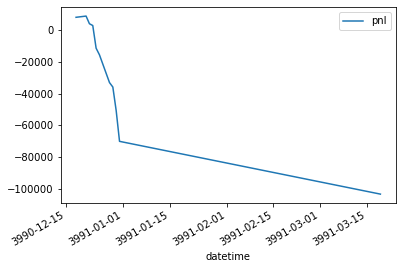

In [58]:
df.set_index('datetime').cumsum().plot()#[datetime(2022,1,1):].cumsum()#.plot()# [datetime(2022,1,1):]

In [511]:
def PlotVWAP(api, ticker, date=datetime(2021,2,18), window=5, ma_len=3, ma_len2=5):
    df = ReadData(api, ticker, date)
#     print(df.head)
#     return
    barG = BarGenerator(ticker=ticker, window=window, date=date)
    for row in df.itertuples():
        tick = TickData(time=row.datetime, close=row.close,volume=row.volume)
        update_bar = barG.updateBar(tick)

    bar_df = pd.DataFrame(barG.bars)
    bar_df['tPrice'] = bar_df[['high','low','close']].mean(axis=1)
    bar_df['v_cumsum'] = bar_df.volume.cumsum()
    bar_df['tP_v_sum'] = (bar_df['tPrice'] * bar_df.volume).cumsum()
    bar_df['VWAP'] = bar_df['tP_v_sum'] / bar_df['v_cumsum']
    bar_df['MA'] = bar_df.tPrice.rolling(ma_len).mean()
    bar_df['MA2'] = bar_df.tPrice.rolling(ma_len2).mean()
    
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])
    
    fig.add_trace(go.Candlestick(x=bar_df.time,
                    open=bar_df.open,
                    high=bar_df.high,
                    low=bar_df.low,
                    close=bar_df.close), row=1,col=1)
    fig.add_trace(
        go.Scatter(
            x=bar_df.time,
            y=bar_df.VWAP,
            name="VWAP"
        ), row=1,col=1)
    fig.add_trace(
        go.Scatter(
            x=bar_df.time,
            y=bar_df.MA,
            name="MA"+str(ma_len),
        ), row=1,col=1)
    fig.add_trace(
        go.Scatter(
            x=bar_df.time,
            y=bar_df.MA2,
            name="MA"+str(ma_len2),
        ), row=1,col=1)
    fig.add_trace(go.Bar(x=bar_df.time, y=bar_df.volume, showlegend=False), row=2, col=1)
    fig.show()
    
def plotTrend(api, ticker, date=datetime(2021,2,18), window=5):
    from scipy.stats import linregress
    df = ReadData(api, ticker, date)
    barG = BarGenerator(ticker=ticker, window=window, date=date)
    for row in df.itertuples():
        tick = TickData(time=row.datetime, close=row.close,volume=row.volume)
        update_bar = barG.updateBar(tick)

    data = pd.DataFrame(barG.bars).set_index('time')
#     print("close,high_trend,high,low,low_trend")
    for i in range(3,data.shape[0]):
        try:
            data0 = CalculateTrend(data.copy().iloc[:i],True)
#             print(data.close.iloc[i+1] , round(data0.high_trend.iloc[-1],2), \
#                   data.high.iloc[i+1], data.low.iloc[i+1], round(data0.low_trend.iloc[-1],2))
#             print("close cross high_trend", data.close.iloc[i+1] >= data0.high_trend.iloc[-1])
#             print("close cross low_trend", data.close.iloc[i+1] <= data0.low_trend.iloc[-1])
#             print("kbar touch high_trend", data.close.iloc[i+1] > data0.low_trend.iloc[-1] and data.low.iloc[i+1] <= data0.low_trend.iloc[-1])
#             print("kbar touch low_trend", data.close.iloc[i+1] < data0.high_trend.iloc[-1] and data.high.iloc[i+1] >= data0.high_trend.iloc[-1], '\n')
            if data.close.iloc[i+1] >= data0.high_trend.iloc[-1]:
                direction = "Long Cross Over "
            if data.close.iloc[i+1] <= data0.low_trend.iloc[-1]:
                direction = "Short Cross Over "
            if data.close.iloc[i+1] > data0.low_trend.iloc[-1] and data.low.iloc[i+1] <= data0.low_trend.iloc[-1]:
                direction = "Long Touch "
            if data.close.iloc[i+1] < data0.high_trend.iloc[-1] and data.high.iloc[i+1] >= data0.high_trend.iloc[-1]:
                direction = "Short Touch "
            print(f"Entry {direction} at ", list(data.reset_index().T.to_dict().values())[i+1], '\n')
        except Exception as e:
            print(e)
            pass

In [510]:
open_thresholds.keys()

dict_keys(['1529', '2495', '3035', '3041', '3060', '3443', '3607', '5258', '6698', '8478', '3114', '3128', '3141', '3390', '3466', '3491', '3675', '5351', '5371', '6104', '6156', '6185', '8089'])

In [458]:
PlotVWAP(api, '3675', date, window=5)

In [543]:
plotTrend(api, '2358', date)

Entry Long Touch  at  {'time': Timestamp('2021-12-23 09:20:01'), 'symbol': '2358', 'open': 23.0, 'high': 23.45, 'low': 23.0, 'close': 23.25, 'volume': 418} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 09:25:05'), 'symbol': '2358', 'open': 23.25, 'high': 23.3, 'low': 23.15, 'close': 23.15, 'volume': 311} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 09:30:06'), 'symbol': '2358', 'open': 23.15, 'high': 23.15, 'low': 23.05, 'close': 23.05, 'volume': 153} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 09:35:04'), 'symbol': '2358', 'open': 23.05, 'high': 23.1, 'low': 23.05, 'close': 23.1, 'volume': 42} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 09:40:54'), 'symbol': '2358', 'open': 23.1, 'high': 23.15, 'low': 23.1, 'close': 23.15, 'volume': 20} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 09:45:08'), 'symbol': '2358', 'open': 23.15, 'high': 23.15, 'low': 22.95, 'close': 23.05, 'volume': 191} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 09:50:11'), 'symbol': '2358', 'open': 23.05, 'high': 23.15, 'low': 23.0, 'close': 23.0, 'volume': 20} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 09:55:21'), 'symbol': '2358', 'open': 23.0, 'high': 23.05, 'low': 23.0, 'close': 23.0, 'volume': 44} 



Entry Long Touch  at  {'time': Timestamp('2021-12-23 10:00:18'), 'symbol': '2358', 'open': 23.0, 'high': 23.0, 'low': 22.95, 'close': 23.0, 'volume': 86} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 10:05:17'), 'symbol': '2358', 'open': 22.95, 'high': 23.0, 'low': 22.9, 'close': 22.95, 'volume': 223} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 10:10:10'), 'symbol': '2358', 'open': 22.9, 'high': 22.95, 'low': 22.9, 'close': 22.95, 'volume': 72} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 10:15:43'), 'symbol': '2358', 'open': 23.0, 'high': 23.0, 'low': 22.9, 'close': 22.9, 'volume': 45} 



Entry Long Touch  at  {'time': Timestamp('2021-12-23 10:21:22'), 'symbol': '2358', 'open': 22.9, 'high': 23.05, 'low': 22.9, 'close': 23.0, 'volume': 57} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 10:26:16'), 'symbol': '2358', 'open': 23.0, 'high': 23.0, 'low': 22.95, 'close': 22.95, 'volume': 10} 



Entry Short Touch  at  {'time': Timestamp('2021-12-23 10:30:46'), 'symbol': '2358', 'open': 23.0, 'high': 23.0, 'low': 22.95, 'close': 22.95, 'volume': 37} 



Entry Long Touch  at  {'time': Timestamp('2021-12-23 10:35:50'), 'symbol': '2358', 'open': 22.95, 'high': 22.95, 'low': 22.9, 'close': 22.95, 'volume': 7} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 10:40:51'), 'symbol': '2358', 'open': 22.9, 'high': 22.95, 'low': 22.9, 'close': 22.9, 'volume': 15} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 10:45:12'), 'symbol': '2358', 'open': 22.95, 'high': 22.95, 'low': 22.95, 'close': 22.95, 'volume': 12} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 10:50:31'), 'symbol': '2358', 'open': 22.95, 'high': 22.95, 'low': 22.95, 'close': 22.95, 'volume': 6} 



Entry Long Touch  at  {'time': Timestamp('2021-12-23 10:55:34'), 'symbol': '2358', 'open': 22.95, 'high': 22.95, 'low': 22.9, 'close': 22.95, 'volume': 20} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:00:03'), 'symbol': '2358', 'open': 22.95, 'high': 23.0, 'low': 22.95, 'close': 23.0, 'volume': 50} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:07:35'), 'symbol': '2358', 'open': 23.0, 'high': 23.0, 'low': 22.95, 'close': 22.95, 'volume': 13} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:10:04'), 'symbol': '2358', 'open': 22.95, 'high': 22.95, 'low': 22.95, 'close': 22.95, 'volume': 41} 



Entry Short Cross Over  at  {'time': Timestamp('2021-12-23 11:16:40'), 'symbol': '2358', 'open': 22.9, 'high': 22.95, 'low': 22.9, 'close': 22.9, 'volume': 21} 



Entry Long Touch  at  {'time': Timestamp('2021-12-23 11:20:02'), 'symbol': '2358', 'open': 22.9, 'high': 22.95, 'low': 22.9, 'close': 22.95, 'volume': 13} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:27:02'), 'symbol': '2358', 'open': 22.95, 'high': 23.0, 'low': 22.95, 'close': 23.0, 'volume': 51} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:30:49'), 'symbol': '2358', 'open': 23.0, 'high': 23.0, 'low': 22.95, 'close': 23.0, 'volume': 49} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:35:11'), 'symbol': '2358', 'open': 23.05, 'high': 23.15, 'low': 23.05, 'close': 23.1, 'volume': 146} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:40:37'), 'symbol': '2358', 'open': 23.1, 'high': 23.25, 'low': 23.1, 'close': 23.15, 'volume': 277} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:45:01'), 'symbol': '2358', 'open': 23.25, 'high': 23.3, 'low': 23.2, 'close': 23.2, 'volume': 149} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:50:13'), 'symbol': '2358', 'open': 23.25, 'high': 23.35, 'low': 23.25, 'close': 23.35, 'volume': 212} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 11:55:11'), 'symbol': '2358', 'open': 23.3, 'high': 23.6, 'low': 23.3, 'close': 23.5, 'volume': 728} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 12:00:01'), 'symbol': '2358', 'open': 23.5, 'high': 23.55, 'low': 23.35, 'close': 23.35, 'volume': 215} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 12:05:03'), 'symbol': '2358', 'open': 23.35, 'high': 23.4, 'low': 23.35, 'close': 23.4, 'volume': 91} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 12:10:09'), 'symbol': '2358', 'open': 23.4, 'high': 23.5, 'low': 23.35, 'close': 23.45, 'volume': 91} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 12:15:35'), 'symbol': '2358', 'open': 23.45, 'high': 23.45, 'low': 23.35, 'close': 23.4, 'volume': 85} 



Entry Long Cross Over  at  {'time': Timestamp('2021-12-23 12:20:07'), 'symbol': '2358', 'open': 23.4, 'high': 23.4, 'low': 23.35, 'close': 23.4, 'volume': 107} 



KeyboardInterrupt: 

In [99]:
40.4/40.25

1.0037267080745342